# GARCH models 
https://medium.com/@corredaniel1500/forecasting-volatility-deep-dive-into-arch-garch-models-46cd1945872b

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

- Efficient Market Hypothesis:

The efficient market hypothesis states that the price of a stock is reflective of an efficient market — that is, all information about the company is reflected in the current value of the stock. While controversial, this view is at the basis of a lot of economic theory. Under this framework, there does not exist an essentially riskless or minimally riskless profit-taking because there are no market inefficiencies that lead to a difference between a current stock value and its actual value, i.e., no arbitrage can exist. It implies that consistently beating the market is impossible based on information about the price of a security up until time t, since all information is available publicly through time t.

This can be mathematically expressed in the following way:

$$E[X_{t}|X_{t-1},X_{t-2},\cdot\cdot\cdot]=0$$

where Xₜ is the current asset price/return and we condition on all previous prices/returns.


- Volatility Clustering

We are able to capture volatility clustering — periods of high volatility or low volatility — via modeling with ARCH. Thus, we can leverage these notions of risk and volatility in the hopes of making profits on assets while still abiding by the principles of the efficient market hypothesis, which limit us to producing trivial, non-informative responses to the conditional expected value of a stock or return at time t.

- Returns

Let's take a small detour to mention the modeling of returns rather than prices. This is a convenient way to model financial assets and as such will be important to conceptualize.

Let Rₜ denote the return of an asset at time t, Pₜ denote the price of the asset at time t and Pₜ₋₁ denote the price of the asset at the previous time period t-1. We can formulate the one-period return of an asset as follows:

$$R_{t}={\frac{P_{t}-P_{t-1}}{P_{t-1}}}$$

Let rₜ denote log return, which is more commonly used because log returns have an additive property that simple returns do not. We formulate the one-period log return of an asset as follows:

$$r_{t}=l o g(\frac{P_{t}}{P_{t-1}})=l o g P_{t}-l o g P_{t-1}$$


## ARCH model
### Model Framework

The model we will use for this is called auto-regressive conditional heteroskedastic model of order P, ARCH(P).

Recall, in various cases such as linear regression and even the ARMA(p,q) model, we want a homoskedastic model (constant variance across observations). However, in this case, we specify that there is actually heteroskedasticity (non-constant variance). Since volatility is conceptually linked with variance, we are interested in modeling how the variance changes over time.

### Model Statement



$${\bf X}_{t}=\sigma_{t}\epsilon_{t}~\mathrm{with}~\sigma_{t}^{2}=b_{0}+\sum_{j=1}^{p}b_{j}X_{t-j}^{2}$$

where $\varepsilon_t$ is IID(0,1) and $b_0, b_1, \ldots, b_p > 0$.

$X_t$ can be the price, returns, or log returns of an asset, modeled by the sum of its squared historical values $X^2_{t-j}$. For simplicity, we define $X_t$ to be the log returns of an asset.

In expectation, $X_t^2$ is the marginal variance of the log returns. Why is this the case? Recall the relationship between variance and expected value of $\text{var}(X) = E[X^2] - (E[X])^2$. We know that $E[X_t] = 0$ because expected returns are trivially 0 due to the efficient market hypothesis. Thus, $E[X_t]^2 = 0$, and we are left with the marginal variance $\sigma^2 = E[X_t^2]$, which is constant and does not depend on $t$.

We build on the concept of constant marginal variance to incorporate heteroskedasticity by modeling the volatility at time $t$ ($\sigma^2_t$), which is the conditional variance of the time series and is directly influenced by the squared log return $X_t^2$.

We can use all of the above to intuitively see that if $X_t$ swings rapidly (i.e., the log return increases or decreases swiftly), $X_t^2$ is high, and thus the volatility $\sigma^2_t$ at time $t$ is high. This is how ARCH models capture price swings and their impact on the volatility of an underlying asset.

## GARCH model
### Model Statement

$$X_{t}=\sigma_{t}\epsilon_{t}{\mathrm{~with~}}\sigma_{t}^{2}=b_{0}+\sum_{j=1}^{p}b_{j}X_{t-j}^{2}+\sum_{j=1}^{n}a_{j}\sigma_{t-j}^{2}$$


where $\varepsilon_t$ is IID(0,1) and $b_0, b_1, \ldots, b_p, a_0, a_1, \ldots, a_n \neq 0$.

### Model Framework
GARCH is the generalized auto-regressive conditional heteroskedastic model of order $(P,Q)$ and is an extension of the ARCH $(P)$ model. We notice the additional term shown above when defining the conditional variance (volatility $\sigma_t^2$ at time $t$), which allows for modeling of the conditional variance to be dependent on lagged versions of itself using a linear combination of $a_0, a_1, \ldots, a_n$ and the conditional variances at previous times. This addition to the model statement makes GARCH models more flexible and able to capture the persistence of volatility.

We can thus reduce the model statement by decomposing the parts of the model into:

- ARCH effects: effects attributed to allow for lagged squared log returns $X_t^2$.
    
- GARCH effects: effects attributed to allow for lagged conditional variances $\sigma_t^2$.


In [1]:
import utils.functions as f
from datetime import datetime
import numpy as np

START_DATE = datetime(2021, 1, 1) 
END_DATE = datetime(2023, 4, 1)
MID_DATE = datetime(2022, 6, 1)

In [4]:
STOCK = 'AAPL'
df = f.get_stock_data(STOCK, START_DATE, END_DATE)
df.head()

[*********************100%***********************]  1 of 1 completed


,date,open,high,low,close,adj_close,volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002090,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572296,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244362,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.484009,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,129.592987,105158200


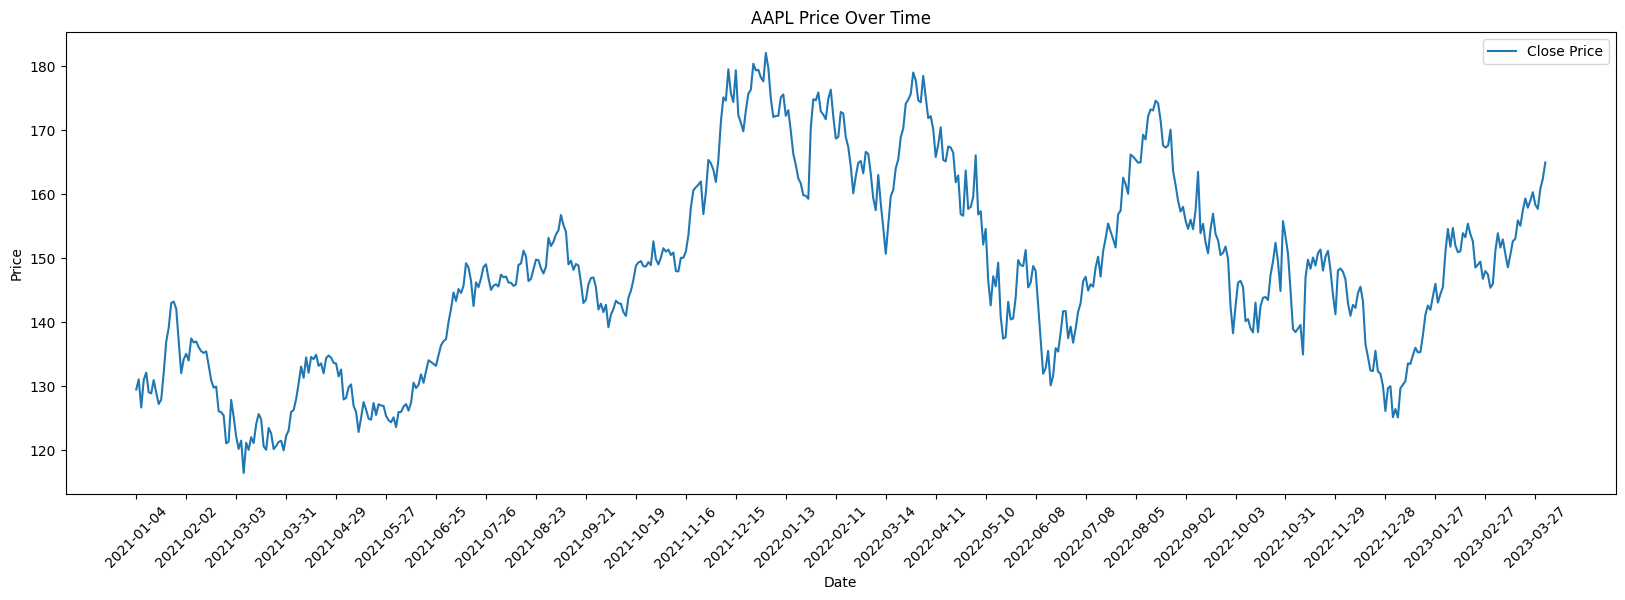

In [5]:
f.plot_stock_data(df, "close", STOCK)

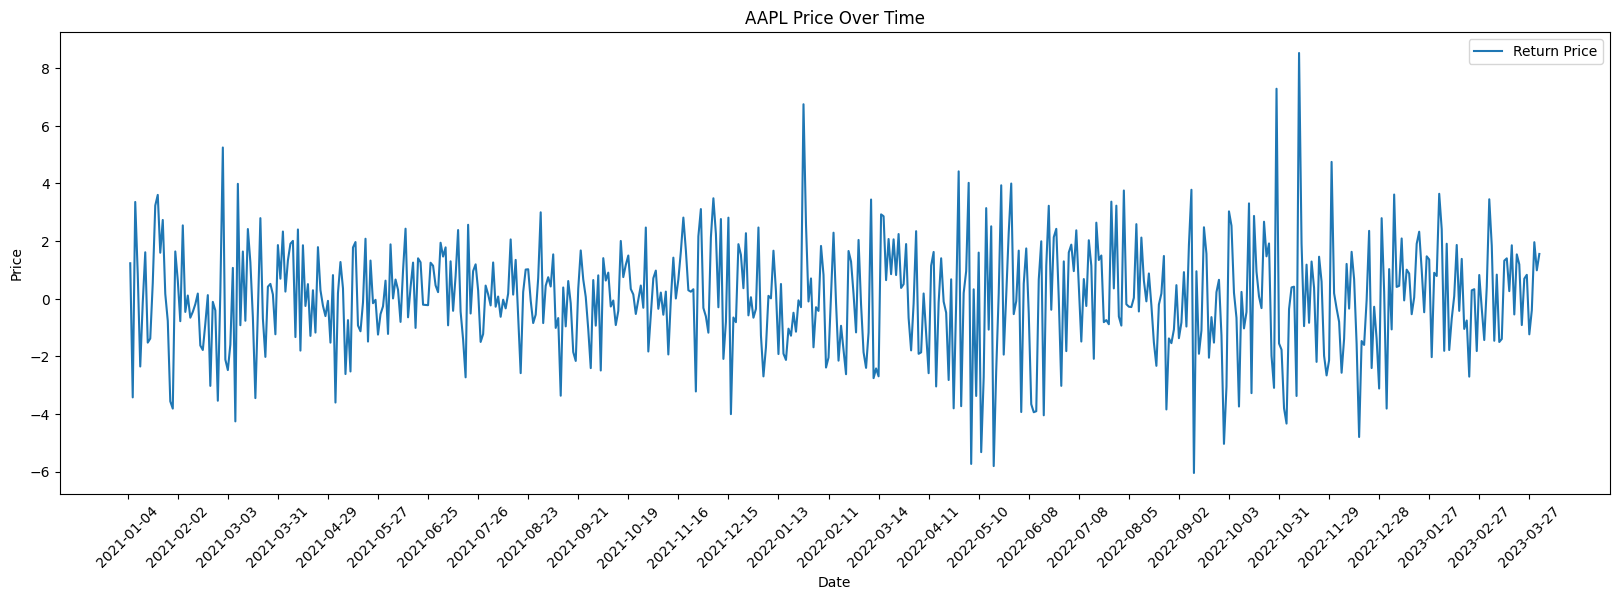

In [9]:
# Convert prices to log returns 
df['return'] = np.pad(np.diff(np.log(df['close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
f.plot_stock_data(df, "return", STOCK)

We then generate autocorrelation (ACF) and partial autocorrelation (PACF) plots to visualize how previous returns with different lags are correlated with one another. Recall that because of properties of stationarity, the correlation and covariance at different points in time should be the same for the same gap — also know as lag h — regardless of the exact point in time t. That is, ACF and PACF should be constant across the same lag in time and should depend only on the lag h and not directly on t. A more detailed explanation is available in the previous article.

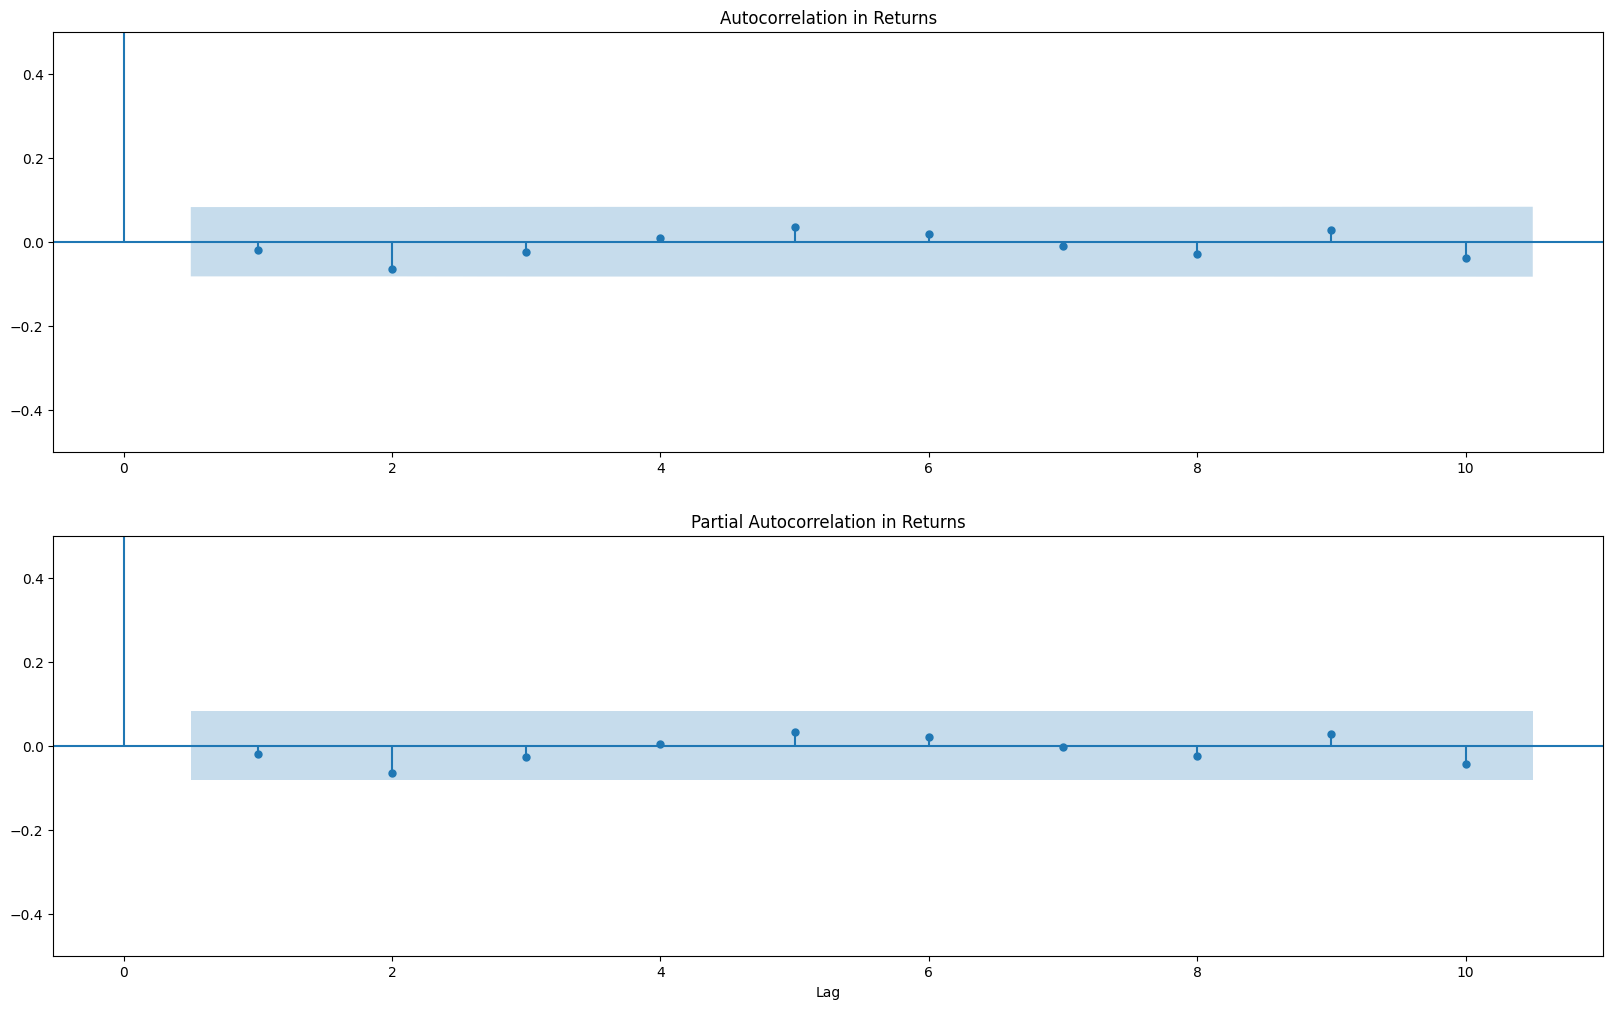

In [17]:
# Plot ACF and PACF
diff_ts = df['return'].iloc[1:]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5) 
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)  
ax2.set_xlabel("Lag")  
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

The above ACF and PACF plots do not indicate that there are ARCH and GARCH effects present. In particular, we would want indication to believe the series in not independent, which would visually be seen as lags for which the ACF and PACF values are outside the blue area. This would imply a significant difference in the ACF or PACF from 0 and would allow us to model the ARCH effects.

To ensure that this is an independent series, or rather to test that it is not, we remember that an independent series is one in which transformations of the series are themselves independent. Thus, we can repeat the process above using the squared returns or the absolute returns. We utilize the absolute returns, as this is generally done in financial data to diminish the effects of outliers.

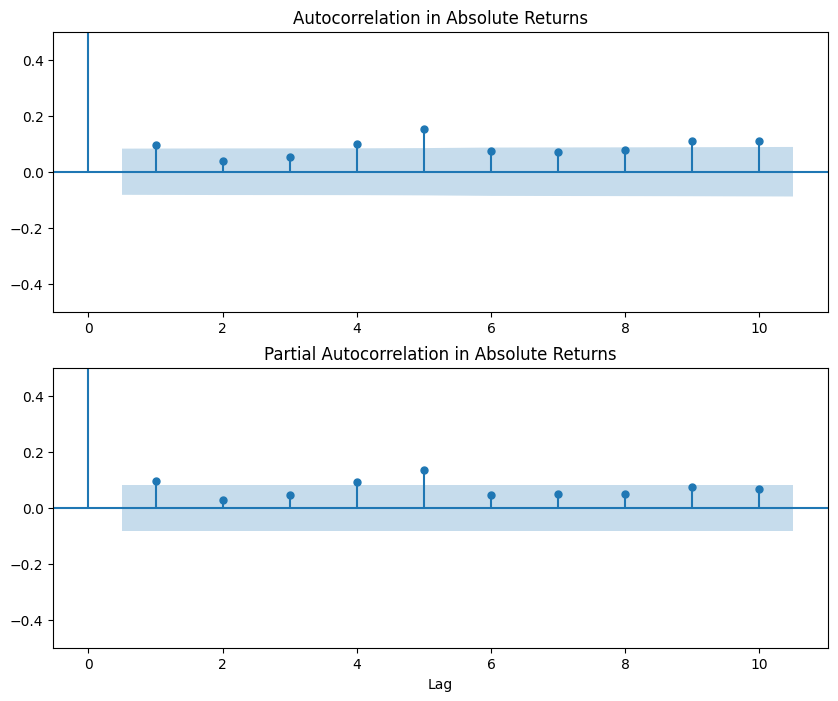

In [18]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5) 
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)  
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")  

plt.show();

After the above transformation to absolute returns, there is now a pattern indicative of ARCH and GARCH effects being present. In the PACF, there is not a big drop until about lag 4, which might indicate that we should have an order of P,Q up to 4. For simplicity and illustration we will use a GARCH(1,1) model before assessing and testing different specifications. We will more formally test these effects using the McLeod-Li test for ARCH and GARCH effects. The nuances and mathematical formulations of the test statistics are left out below but the concept and hypothesis are summarized.

- McLeod-Li Test

The McLeod-Li test proposes the following null and alternative hypotheses to test for white noise behavior in the residuals of the series:

* H₀: there are no ARCH effects in the time series

* Hₐ: there are ARCH effects in the time series

We thus first fit a model of GARCH(1,1) and then apply the McLeod-Li test to the residuals. The result of the test is a p-value < 0.001 and thus we conclude that there are ARCH effects in the time series.

In [19]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  147.69650082130912
p-value:  1.387745474090707e-11


## Fit GARCH(P,Q) Model

Below, we fit the GARCH(1,1) model to the data. We implement the process by using a training and testing data split of 80%/20%, with more recent historical data serving as the test set.

We use arch_model() from the arch package and specify that the data is of mean zero and modeled with a GARCH process. We specify the arguments of P,Q as 1,1 and choose not to standardize (“rescale”) the data.

In [20]:
# Fit GARCH (1,1)
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 243674102.27349234
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1115.1755612783022
Iteration:      3,   Func. Count:     19,   Neg. LLF: 905.1001517527252
Iteration:      4,   Func. Count:     24,   Neg. LLF: 903.9357987570703
Iteration:      5,   Func. Count:     29,   Neg. LLF: 904.0730612405055
Iteration:      6,   Func. Count:     34,   Neg. LLF: 903.6942620559021
Iteration:      7,   Func. Count:     38,   Neg. LLF: 903.6942372831535
Iteration:      8,   Func. Count:     41,   Neg. LLF: 903.6942372839594
Optimization terminated successfully    (Exit mode 0)
            Current function value: 903.6942372831535
            Iterations: 8
            Function evaluations: 41
            Gradient evaluations: 8


We recall the GARCH(P,Q) model statement from above and provide estimates for the parameters as a result of our GARCH model fit:
$$X_{t}=\sigma_{t}\epsilon_{t}{\mathrm{~with~}}\sigma_{t}^{2}=b_{0}+\sum_{j=1}^{p}b_{j}X_{t-j}^{2}+\sum_{j=1}^{n}a_{j}\sigma_{t-j}^{2}$$


where $\varepsilon_t$ is IID(0,1) and $b_0, b_1, \ldots, b_p, a_0, a_1, \ldots, a_n \neq 0$.

Our fitted model is as follows:

In [37]:
print(f"sigma^2_t = {res_garch.params['omega']:.2f} + {res_garch.params['alpha[1]']:.2f} r^2_t-1 + {res_garch.params['beta[1]']:.2f} sigma^2_t-1")


sigma^2_t = 0.05 + 0.05 r^2_t-1 + 0.94 sigma^2_t-1


where $\sigma_t^2$ is the conditional variance at time $t$, $X^2_{t-1}$ is the squared return at time $t-1$, and $\sigma^2_{t-1}$ is the conditional variance at time $t-1$.

## Forecasting Volatility
### N-Step Ahead Forecast

Using the GARCH model from above, we are able to forecast volatilities $\sigma_t^2$ at time $t$, which are non-trivial predictions. The model makes these forecasts by accessing data from log returns $X_t$ from which $\sigma_{t+n}^2$ can be calculated (n-step-ahead forecast). We then use these forecasts to extend the forecast of volatility to times $t+1$, $t+2$, ..., $t+n$. We do not continually update $X_t$ as time $t$ increases, but rather limit our forecasts for all future dates to be made solely on the current date.

The following plots show our predicted volatility using this method.

In [38]:
# Forecast the test set 
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)

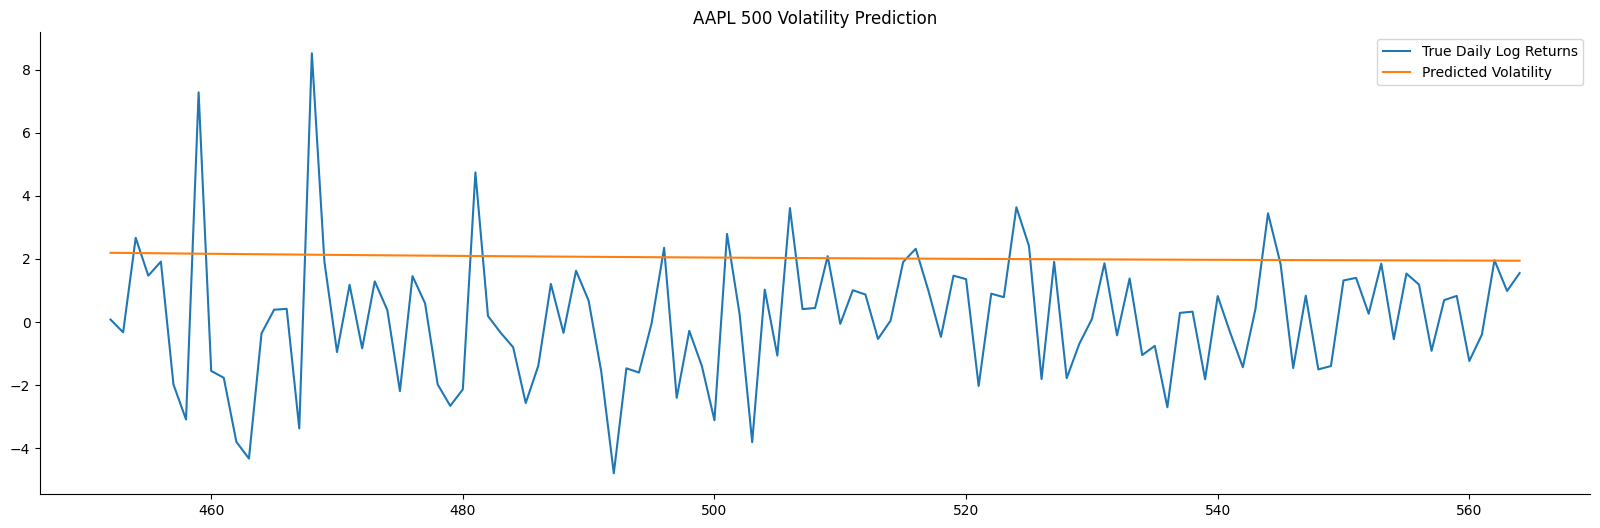

In [49]:
fig,ax = plt.subplots(figsize=(20,6))
ax.spines[['top','right']].set_visible(False)
# Plot test set returns
plt.plot(diff_ts[-y_test.shape[0]:])
# Plot volatility estimates for test set
plt.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
plt.title(f'{STOCK} 500 Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])

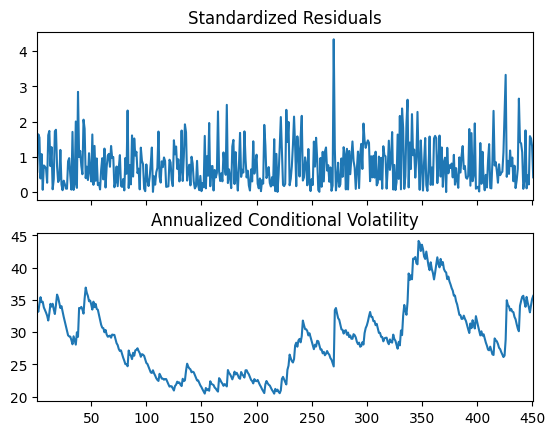

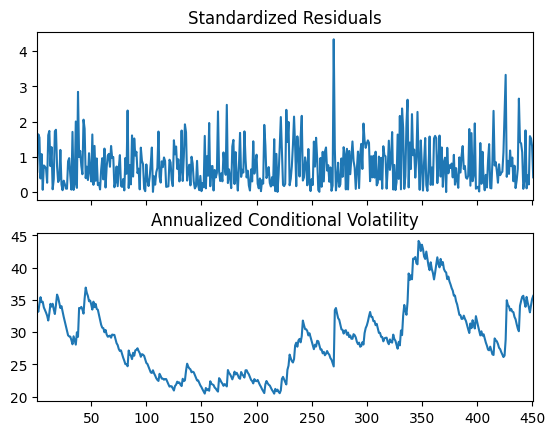

In [40]:
# Conditional volatility by model fitting
res_garch.plot(annualize="D")

### One-Step Ahead Rolling Forecast

Another suitable and more pragmatic approach would be to only make one-step ahead predictions based on information up until time $t$ and update the information to the model in real time as time $t$ becomes $t+1$, $t+2$, etc. More simply, with each passing day, we update $X_t$, $X_{t+1}$, $X_{t+2}$ with the actual, observed return from that day to model one time step ahead.

Below, we see how well this rolling volatility prediction is able to capture the volatility in our unseen test data.

In [41]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

Text(0.5, 1.0, 'AAPL 500 Rolling Volatility Prediction')

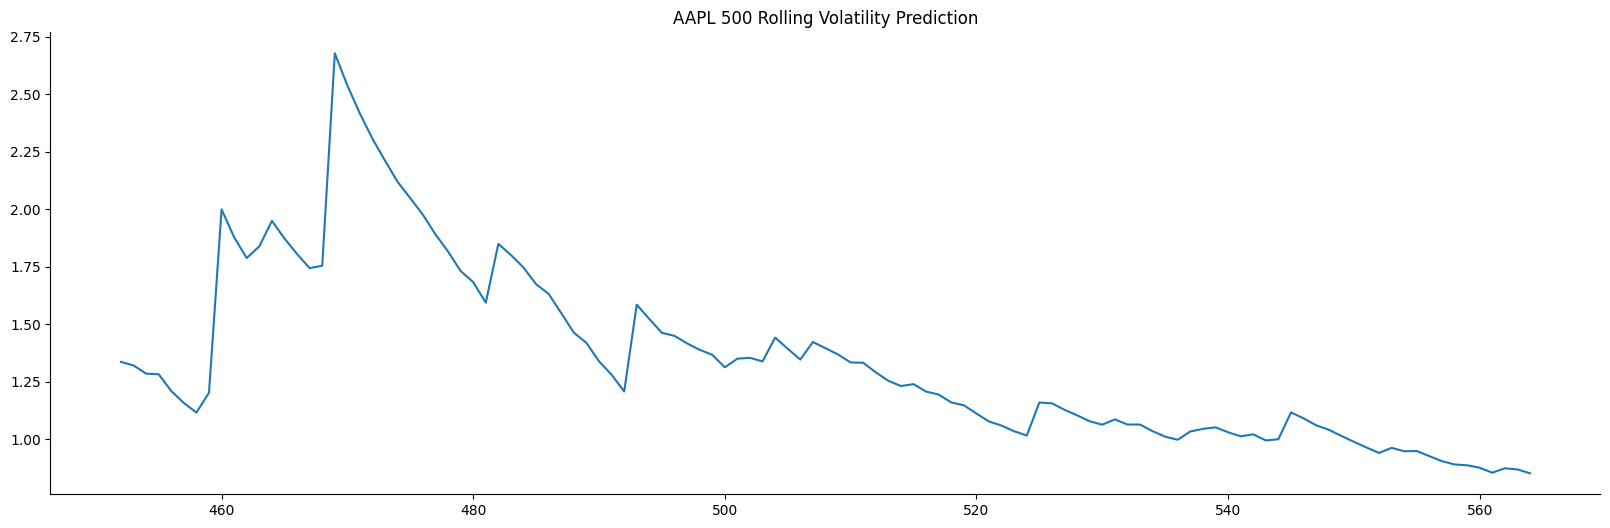

In [46]:
# Plot of predicted test data rolling volatility predictions
fig,ax = plt.subplots(figsize=(20,6))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title(f'{STOCK} 500 Rolling Volatility Prediction')

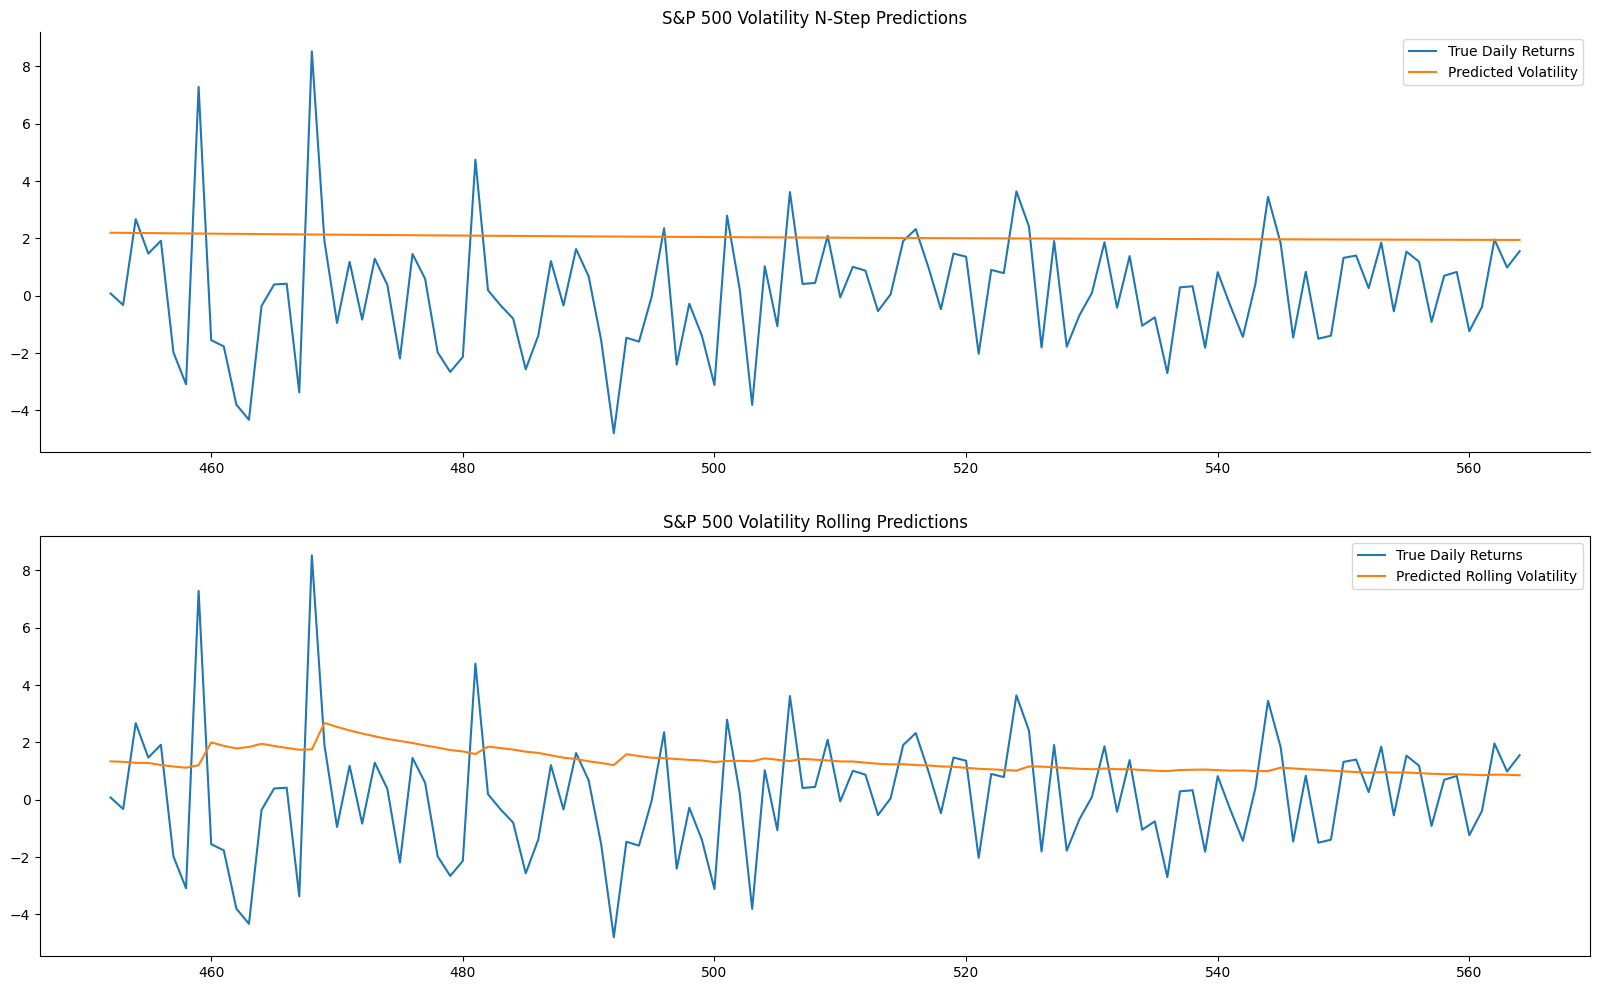

In [47]:
# Compare n-step-ahead and one-step-ahead rolling predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
plt.show()

## Model Diagnostics

Since model diagnostics are often an overlooked step, we will spend some time assessing whether our fitted model is valid and provide direction for next steps.

## Jarque-Bera Test

We make an assumption in the GARCH$(P,Q)$ model about the distribution of our errors: if the model is specified correctly, then the errors are normally distributed with mean 0 and constant variance. The Jarque-Bera test checks if the model errors are normally distributed.

The formula for the test statistic is as follows:

$
JB = \frac{n}{6}\left(S^2 + \frac{1}{4}(K - 3)^2\right)
$

where $n$ is the size of the data, $S$ is the sample skewness (which measures the symmetry of the data relative to the mean) and $K$ is the sample kurtosis (which measures the shape of distribution, especially the tails).

We know that the kurtosis of the normal distribution is 3, which is useful as a reference. If greater than 3, we have a sample that is heavier-tailed than the normal distribution. If less than 3, we have a sample that is lighter-tailed than the normal distribution.

We can gather the intuition that using the symmetry and shape of the sample relative to known values for the normal distribution would help us arrive at the following hypothesis:

$
H_0: \text{The data has a normal distribution.}
$

$
H_a: \text{The data does not have a normal distribution.}
$

In [45]:
# Calculate the standardized residuals on the test data
std_resid = res_garch.resid / res_garch.conditional_volatility

# Perform Jarque-Bera test using scipy.stats
jb_test = jarque_bera(std_resid)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 212.1637195103575
p-value: 8.496375115532057e-47


## Conclusion

Our journey into ARCH and GARCH models took us away from the general framework of mean modeling to variance modeling. It took us to economics and the efficient market hypothesis and finely combed through the math that builds these powerful models. It gave us tools in the EDA phase to recognize when to use the ARCH and GARCH models. We fit models and built forecasts that could be done on a rolling basis to predict the volatility in the most practical manner. Lastly, we ended on an exploration of what can we do to improve our model by subtly changing our assumptions.

On that final note, we can modify the ARCH and GARCH approaches many different ways. Importantly, we can choose to combine this GARCH approach with an ARMA model to give rise to the ARMA + GARCH model. Stay tuned for the next post to read about this versatile approach!